In [ ]:
# Connect to the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import library
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
from keras import optimizers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from numpy import savetxt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Wanliu.csv to Wanliu.csv


In [ ]:
data=read_csv("Wanliu.csv")
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,1,2013,3,1,0,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2,2013,3,1,1,9.0,9.0,6.0,28.0,400.0,50.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,3,2013,3,1,2,3.0,6.0,NaN,19.0,400.0,55.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,4,2013,3,1,3,11.0,30.0,8.0,14.0,NaN,NaN,-1.4,1024.5,-19.4,0.0,NW,3.1
4,5,2013,3,1,4,3.0,13.0,9.0,NaN,300.0,54.0,-2.0,1025.2,-19.5,0.0,N,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,27.0,4.0,20.0,300.0,81.0,12.6,1011.9,-14.3,0.0,N,2.0
35060,35061,2017,2,28,20,15.0,43.0,6.0,55.0,500.0,45.0,9.4,1012.3,-11.9,0.0,WSW,1.0
35061,35062,2017,2,28,21,13.0,35.0,7.0,48.0,500.0,48.0,8.7,1012.8,-13.7,0.0,N,1.1
35062,35063,2017,2,28,22,12.0,31.0,5.0,47.0,500.0,50.0,7.8,1012.9,-12.6,0.0,NNE,1.0


In [ ]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('Wanliu.csv',index_col=0, date_parser=parse,parse_dates=[['year', 'month', 'day', 'hour']])

In [ ]:
dataset.drop("No", axis=1, inplace=True)

In [ ]:
dataset=dataset.fillna(method="pad")

In [ ]:
dataset.isnull().sum()

PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64

In [ ]:
dataset_columns = dataset.columns.tolist()
dataset_columns

['PM2.5',
 'PM10',
 'SO2',
 'NO2',
 'CO',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'wd',
 'WSPM']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = dataset.values
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])
values = values.astype('float32')
values[:,10]

array([6., 3., 6., ..., 3., 5., 4.], dtype=float32)

In [ ]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [ ]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [ ]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (35060, 1)
X (35060, 4, 12)


In [ ]:
#Splitting the dataset
n_train = 24*365
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (26300, 4, 12)
X_test (8760, 4, 12)
Y_train (26300, 1)
Y_test (8760, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')

In [ ]:
history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size = 64, verbose=1)

Epoch 1/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 2/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 7/100
411/411 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/100
411/411 [==============================] - 1s 3ms/step - loss: 9.7395e-04 - val_loss: 0.0014
Epoch 9/100
411/411 [==============================] - 1s 4ms/step - loss: 9.6832e-04 - val_loss: 0.0013
Epoch 10/100
411/411 [==============================] - 2s 5ms/step - loss: 9.7215e

In [ ]:
from keras.models import load_model
model_cnn.save('AirPollutionCNN.h5')

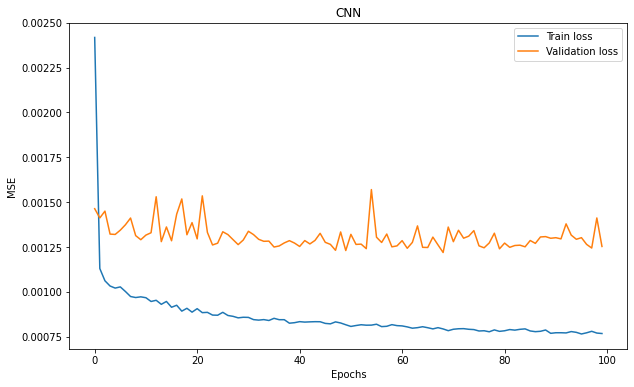

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("CNN")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
plt.savefig('graph_CNN.png')

In [ ]:
RMSE1=[]
RMAE1=[]
MAPE1=[]
R22=[]

for i in range(40, 181, 5):
  Y_pred = model_cnn.predict(X_test[:i,:])
  print(Y_pred.shape)
  #print(Y_pred)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:i,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  Y_predicted = scaler.inverse_transform(Y_predicted)
  Y_tested = scaler.inverse_transform(Y_tested)
  Y_predicted = Y_predicted[:,0:1]
  Y_tested = Y_tested[:i,0:1]
  mse = mean_squared_error(Y_tested, Y_predicted)
  rmse = np.sqrt(mse)
  print("RMSE at %s = %s" % (i, rmse))
  RMSE1=np.append(RMSE1,rmse)
  mae = mean_absolute_error(Y_tested, Y_predicted)
  rmae = np.sqrt(mae)
  RMAE1=np.append(RMAE1,rmae)
  print("RMAE at %s = %s" % (i, rmae))
  mape = mean_absolute_percentage_error(Y_tested, Y_predicted)
  print("MAPE at %s = %s" % (i, mape))
  MAPE1=np.append(MAPE1,mape)
  #R2 score
  R2 = r2_score( Y_predicted, Y_tested)
  print("R2 at %s = %s" % (i, R2))
  R22=np.append(R22,R2)

2/2 [==============================] - 0s 5ms/step
(40, 1)
RMSE at 40 = 6.317168
RMAE at 40 = 2.2917094
MAPE at 40 = 0.84009886
R2 at 40 = 0.8133659735874249
2/2 [==============================] - 0s 6ms/step
(45, 1)
RMSE at 45 = 6.4840612
RMAE at 45 = 2.3297908
MAPE at 45 = 0.7559282
R2 at 45 = 0.9389180853671475
2/2 [==============================] - 0s 6ms/step
(50, 1)
RMSE at 50 = 8.562178
RMAE at 50 = 2.5880399
MAPE at 50 = 0.69997436
R2 at 50 = 0.9384156030922334
2/2 [==============================] - 0s 6ms/step
(55, 1)
RMSE at 55 = 9.664331
RMAE at 55 = 2.7311084
MAPE at 55 = 0.6504712
R2 at 55 = 0.9317720739337995
2/2 [==============================] - 0s 7ms/step
(60, 1)
RMSE at 60 = 9.77427
RMAE at 60 = 2.7618582
MAPE at 60 = 0.6058935
R2 at 60 = 0.9373586628253259
3/3 [==============================] - 0s 4ms/step
(65, 1)
RMSE at 65 = 13.631602
RMAE at 65 = 2.9646828
MAPE at 65 = 0.57953984
R2 at 65 = 0.8710296659754214
3/3 [==============================] - 0s 4ms/step
(70

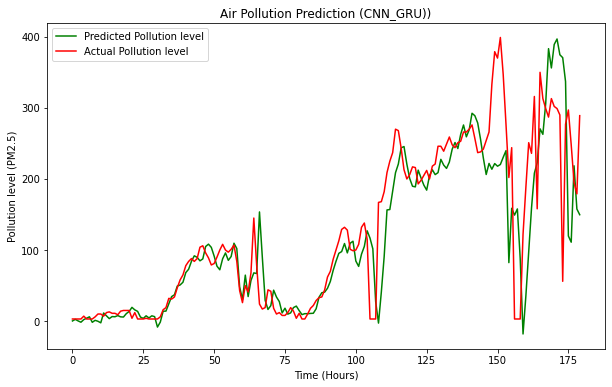

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted, color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_tested , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (CNN_GRU))")
plt.xlabel("Time (Hours)")
plt.ylabel("Pollution level (PM2.5)")
plt.legend()
plt.show()
plt.savefig('graphCNN.png')

In [ ]:
savetxt('Predict_LSTM.csv', Y_predicted, delimiter=',')

In [ ]:
savetxt('Test_LSTM.csv', Y_test, delimiter=',')